## Assignment 6
----

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Functions / Classes
-----

In [15]:
def Clenshaw_Curtis(M, domain = [-1, 1]):
    """
    Calculates M Clenshaw-Curtis nodes on the specified interval
    NOTE give values 2**(n) + 1 for sequence of n = 1,2,... for nested nodes of lecture slides
    """
    nodes = []
    dom_len = domain[1]-domain[0]
    dom_shift = domain[0]

    nodes = dom_len/2*(np.cos(np.arange(M)*np.pi/(M-1)) + 1) + domain[0]
    
    return nodes

def Lagrange(Z, Z_vals, k):
    """
    Lagrange k-th polynomial in the point Z and given points Z_val
    """
    res = 1

    for Z_i in Z_vals:
        if Z_i == Z_vals[k]:
            continue
        res *= (Z - Z_i)/(Z_vals[k] - Z_i)

    return res

def residual(w, N, kappa, dx, boundary):
    """
    Residual used in Newton method
    """
    res_val = []

    for k in range(N):
        # boundary cases
        if k == 0:
            res_val.append(w[k] - boundary[0])
        elif k == N-1:
            res_val.append(w[k] - boundary[1])

        # other case
        else:
            res_val.append((w[k+1]**2-w[k-1]**2)/(4*dx) - kappa*(w[k+1]-2*w[k] + w[k-1])/(dx**2))

    return res_val

def System_solver(N, domain, boundary, kappa, steps = 50, res_tol = 10**(-8), update_tol = 10**(-8)):
    """
    Newton solver for Burgers equation
    Python version of burgers_steady_viscous.m from 
    https://people.sc.fsu.edu/~jburkardt/m_src/burgers_steady_viscous/burgers_steady_viscous.html 
    """
    # init function guess -> line between boundary conditions
    w = np.linspace(boundary[0], boundary[1], N)
   
    dx = (domain[1]-domain[0])/(N-1)
    

    Jacobian = np.zeros((N,N))
    step = 0
    while step < steps:
        # get update of residual values
        res_value = residual(w, N, kappa, dx, boundary)

        # see if converged enough in terms of residual
        if np.linalg.norm(res_value, np.inf) < res_tol:
            #print('f conv', step)
            break

        # get update of Jacobian
        for i in range(N):
            # boundary cases
            if i == 0 or i == N-1:
                Jacobian[i][i] = 1
            else:
                Jacobian[i][i] = 2*kappa/(dx**2)
                Jacobian[i][i-1] = -w[i-1]/(2*dx) - kappa/(dx**2)
                Jacobian[i][i+1] = w[i+1]/(2*dx) - kappa/(dx**2)
    
        # get Newton update
        dw = np.linalg.solve(Jacobian, res_value)

        # see if converged enough in terms of step (or update) size
        if np.linalg.norm(dw, np.inf) < update_tol*(np.linalg.norm(w)+1):
            #print('update size convergence', step)
            break


        # update estimate
        w = w - dw

        # increment step count
        step += 1

    return w

class Stoch_Collocation():
    def __init__(self):

        self.Newton_solve_vals = {'test': None}

    def stoch_colloctation(self, N, M, x_vals, kappa, res_tol=10**(-8), update_tol=10**(-8)):
        
        # test if values can be reused from previous runs
        if self.Newton_solve_vals['test'] == None:
            self.Newton_solve_vals['test'] = N
        # if not reset dictionary
        elif self.Newton_solve_vals['test'] != N:
            self.Newton_solve_vals = {'test': N}

        nodes = Clenshaw_Curtis(M, [0.05, 0.35])
        approx = [0 for x in x_vals]

        Lagrange_vals = {}

        for j, z in enumerate(nodes):
            Lagrange_vals[j] = Lagrange(kappa, nodes, j)

            # NOTE only depends on nodes z and N
            if type(self.Newton_solve_vals.get(z, -1)) == int:
                self.Newton_solve_vals[z] = System_solver(N, [-1, 1], [1, -1], z, steps = 50, res_tol=res_tol, update_tol=update_tol)

        for i, x in enumerate(x_vals):
            for j, z in enumerate(nodes):
                approx[i] += self.Newton_solve_vals[z][i]*Lagrange_vals[j]

        return approx

### Mean/Variance
--------

In [16]:
mc_ord = 1000

N, M = 251, 33
x_vals = np.linspace(-1, 1, N)

mc_Z_vals = np.random.rand(mc_ord)*0.3+0.05
results = [[] for x in mc_Z_vals]

SC = Stoch_Collocation()

for i, kappa in enumerate(mc_Z_vals):
    results[i] = SC.stoch_colloctation(N, M, x_vals, kappa)

results_flip = np.array(results).T


mean = np.mean(results_flip, axis=1)
std = np.std(results_flip, axis=1)
# percentiles
perc5 = np.percentile(results_flip, 5, axis=1)
perc95 = np.percentile(results_flip, 95, axis=1)

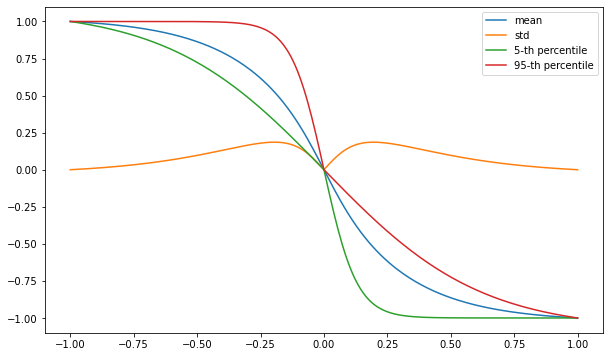

In [17]:
# plots
plt.figure(figsize=(10,6))
plt.plot(x_vals, mean, label='mean');
plt.plot(x_vals, std, label='std');
plt.plot(x_vals, perc5, label='5-th percentile ');
plt.plot(x_vals, perc95, label='95-th percentile');

plt.legend();

Actual x-value used 0.19999999999999996


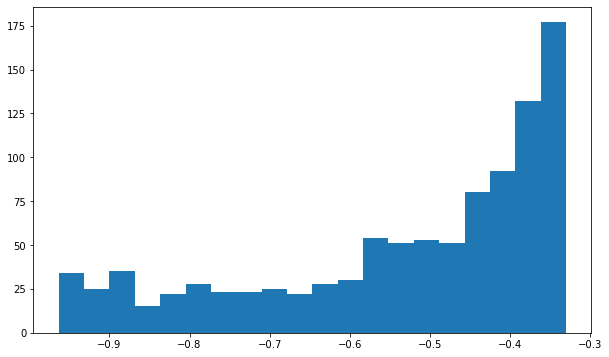

In [18]:
# histogram NOTE if x_vals is redefined somewhere else this can break
index = np.argmin(abs(x_vals-0.2))
print(f'Actual x-value used {x_vals[index]}')
plt.figure(figsize=(10,6))
plt.hist(results_flip[index], bins=20);

### Some questionable error analysis
-----

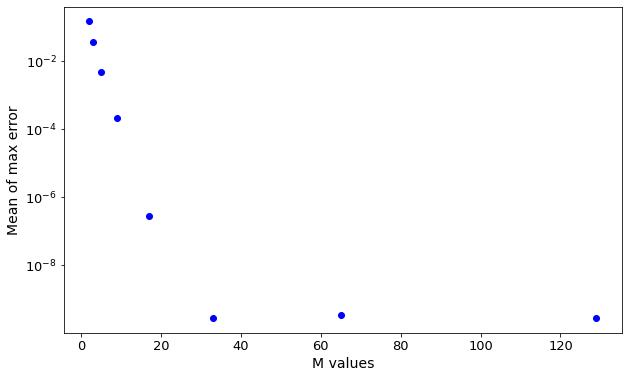

In [38]:
# Computes a mean of max error type of norm
# NOTE: System solver has 10^(-8) as tollerance by default -> changed to 10**(-12) to see if convergence goes beyond this

# From this it can be seen that around M = 33 gives good results not much more can be expected by only increasing M
# Also by testing various values of N it seems to be stable from around N = 250 with error around 10**(-10)

##### see size of error for different values of M #####

# number of grid points
N = 500
x_vals = np.linspace(-1, 1, N)
# values of M to test note these are nested for a nice speedup
M_vals = [2**n + 1 for n in range(8)]
# values of kappa for which to test
kappa_vals = np.linspace(0.05, 0.35, 10)

# init class
SC = Stoch_Collocation()
# init list to store errors
Error_list = []
# Test
for M in M_vals:
    # reset error for current M val
    error = 0
    # get errors for each kappa val
    for kappa in kappa_vals:
        approx = np.array(SC.stoch_colloctation(N, M, x_vals, kappa, res_tol = 10**(-12), update_tol=10**(-12)))
        real = System_solver(N, [-1, 1], [1, -1], kappa, res_tol = 10**(-12), update_tol=10**(-12))
        error += np.linalg.norm(real - approx, np.inf)

    # append mean of max error
    Error_list.append(error/10)

plt.figure(figsize=(10,6))
plt.semilogy(M_vals, Error_list, 'bo');
plt.xlabel('M values', fontsize=14);
plt.ylabel('Mean of max error', fontsize=14);
plt.tick_params('both', labelsize=13);


### TESTS - Ignore
-------

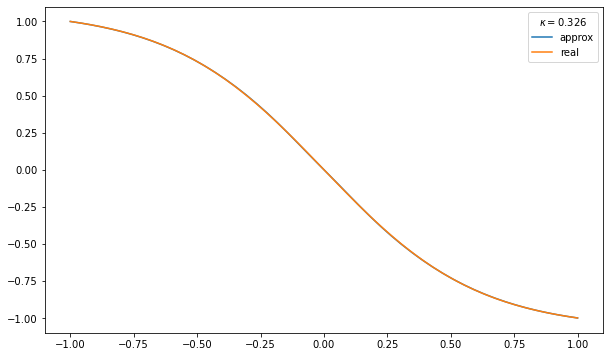

In [7]:
# general test for approximation results

N, M = 50, 2**2 + 1
x_vals = np.linspace(-1, 1, N)
x_vals2 = np.linspace(-1, 1, 250)

kappa = np.random.rand()*0.3+0.05
SC = Stoch_Collocation()

approx = SC.stoch_colloctation(N, M, x_vals, kappa)
real = System_solver(250, [-1, 1], [1, -1], kappa)

plt.figure(figsize=(10,6))
plt.plot(x_vals, approx, label='approx');
plt.plot(x_vals2, real, label='real');

plt.legend(title=f'$\kappa = {round(kappa,3)}$');

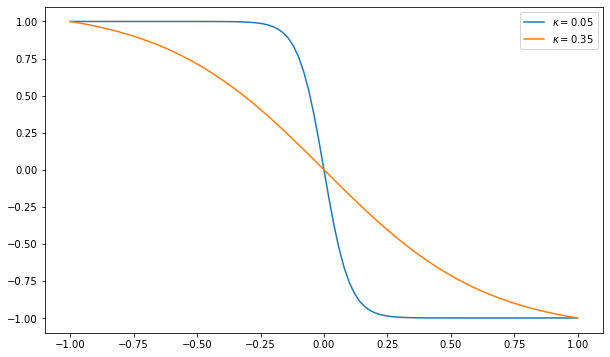

In [17]:
# test for newton solver
N = 101
a = System_solver(N, [-1, 1], [1, -1], 0.05)
b = System_solver(N, [-1, 1], [1, -1], 0.35)

plt.figure(figsize=(10,6))
plt.plot(np.linspace(-1, 1, N), a, label='$\kappa = 0.05$');
plt.plot(np.linspace(-1, 1, N), b, label='$\kappa = 0.35$');

plt.legend();

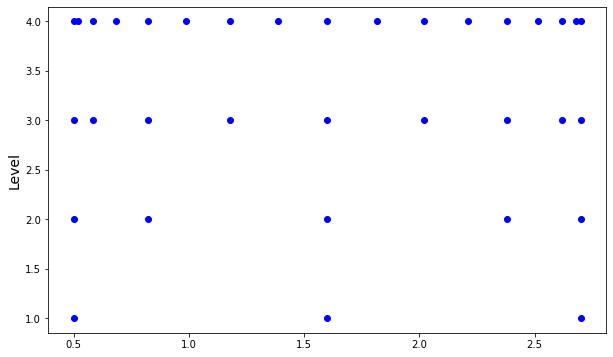

In [29]:
# Clenshaw Curtis nodes test
plt.figure(figsize=(10,6))
plt.ylabel('Level', fontsize=14)
for M in range(1, 5):
    nodes = Clenshaw_Curtis(2**M+1, domain=[.5, 2.7])
    y = [M]*(2**M+1)
    plt.plot(nodes, y, 'bo');

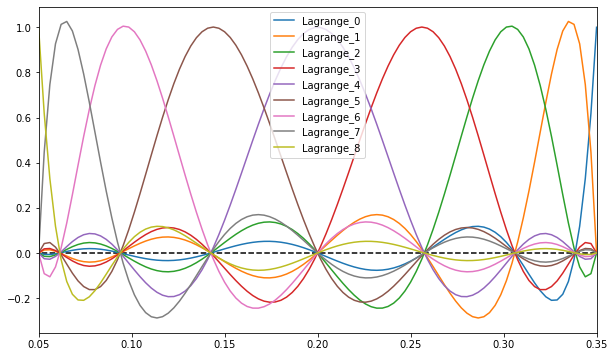

In [27]:
# Lagrange polynomial test
M = 9

Z_vals = Clenshaw_Curtis(M, [0.05, 0.35])

results = [[] for i in range(M)]
for k in range(M):
    x_vals = np.linspace(0.05, 0.35, 100)
    for Z in x_vals:
        results[k].append(Lagrange(Z, Z_vals, k))

plt.figure(figsize=(10,6))
plt.xlim(0.05, 0.35)
plt.hlines(0, -1, 1, color='black', ls='--');
for k in range(M):
    plt.plot(x_vals, results[k], label=f'Lagrange_{k}');

plt.legend();